In [33]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, to_date
import matplotlib.pyplot as plt
!pip install seaborn
import seaborn as sns
import pandas as pd



In [24]:
spark = SparkSession.builder \
        .appName("Umsatz") \
        .config("spark.hadoop.fs.s3a.endpoint", "http://minio:9000") \
        .config("spark.hadoop.fs.s3a.access.key", "minioadmin") \
        .config("spark.hadoop.fs.s3a.secret.key", "minioadmin") \
        .config("spark.hadoop.fs.s3a.path.style.access", True) \
        .config("spark.hadoop.fs.s3a.impl", "org.apache.hadoop.fs.s3a.S3AFileSystem") \
        .config("spark.hadoop.fs.s3a.aws.credentials.provider", "org.apache.hadoop.fs.s3a.SimpleAWSCredentialsProvider") \
        .getOrCreate()

In [28]:
file_path = f"s3a://datawarehouse/revenue_data.csv"
df =  spark.read.csv(file_path, header=True)
print(df.head())

Row(event_time='2019-11-04T19:08:29.000Z', product_id='5400195', main_category='unknown', sub_category='unknown', brand='must', price='41.34')


In [39]:
from pyspark.sql.types import DoubleType

df = df.withColumn("date", to_date(col("event_time")))
df = df.withColumn("price", df["price"].cast(DoubleType()))
daily_sales = df.groupBy("date").sum("price").orderBy("date")


In [44]:
daily_sales_pd = daily_sales.toPandas()

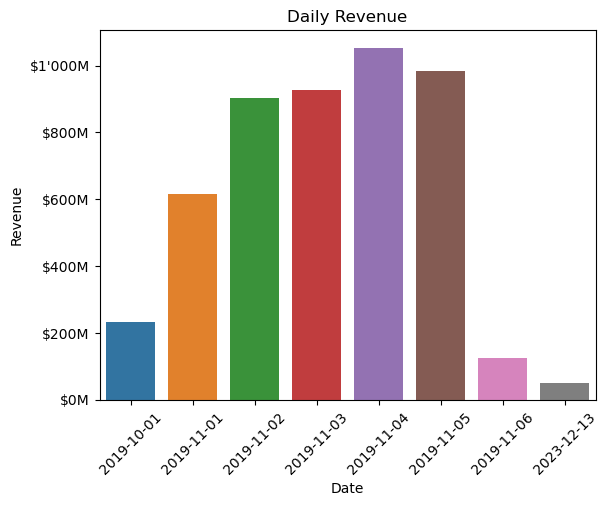

In [54]:
from matplotlib.ticker import FuncFormatter
# Function to format the tick labels
def millions_formatter(x, pos):
    value = f"{int(x/1e6):,}".replace(',', "'")
    return f'${value}M'

# Assuming 'date' is your categorical variable and 'sum(price)' is your numeric variable
sns.barplot(x='date', y='sum(price)', data=daily_sales_pd)
plt.title("Daily Revenue")
plt.xlabel("Date")
plt.ylabel("Revenue")
# Set the y-axis formatter
plt.gca().yaxis.set_major_formatter(FuncFormatter(millions_formatter))

plt.xticks(rotation=45) # Rotate x-axis labels for better readability
plt.show()
